<a href="https://colab.research.google.com/github/jackieshen2013/nyu-python-public-policy/blob/master/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##HOMEWORK 5: The relationship between concentration of homeless shelters and count of 311 requests related to homeless services

Problem Statement: Homelesses is a big concern in New York City. The Department of Homeless Services is tasked with providing services and housing for people who are homeless. They recently began publishing the count of homeless shelter buildings per community district on NYC Open Data to provide more transparency into where shelters are located. The dataset provides counts in multiple columns for different categories of buildings. It also includes counts from different reporting dates.

The 311 Service Requests dataset includes a complaint type called "Homeless Person Assistance". Let's find out if there's a relationship between the number of homeless assistance 311 requests and the concentration of homeless shelter buildings per community district.

In [0]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt 
import numpy as np
import statsmodels.api as sm # package for doing statistics

In [0]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Step 1

Load the datasets:
* Cleaned 311 data that excludes records with invalid community districts. Shared with you on Google Drive as cleaned_311_data_revised.csv

* NYC Open dataset that provides the total count of different types of homeless shelter buildings per community district.
 * Data source page where you can preview the data: https://data.cityofnewyork.us/Social-Services/Buildings-by-Borough-and-Community-District/3qem-6v3v/data
 * CSV data download link you can plug into the pd.read_csv() function: https://data.cityofnewyork.us/api/views/3qem-6v3v/rows.csv?accessType=DOWNLOAD


In [0]:

df = pd.read_csv('/content/drive/My Drive/Data for Python/cleaned_311_data_revised.csv', header='infer')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,19,20,22,33,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:

# Data source for population by Community District: https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Community-Districts/xi7c-iiu2/data
# This time we'll load it directly from NYC Open Data instead of from Google Drive
shelter = pd.read_csv('https://data.cityofnewyork.us/api/views/3qem-6v3v/rows.csv?accessType=DOWNLOAD', header='infer')

In [0]:
shelter.head()

,Report Date,Borough,Community District,Adult Family Comm Hotel,Adult Family Shelter,Adult Shelter,Adult Shelter Comm Hotel,FWC Cluster,FWC Comm Hotel,FWC Shelter
0,07/31/2018,Bronx,201,NaN,1.0,2.0,NaN,4.0,1.0,7.0
1,07/31/2018,Bronx,202,NaN,1.0,NaN,NaN,3.0,NaN,6.0
2,07/31/2018,Bronx,203,NaN,2.0,5.0,NaN,5.0,2.0,9.0
3,07/31/2018,Bronx,204,NaN,NaN,2.0,NaN,18.0,NaN,14.0
4,07/31/2018,Bronx,205,NaN,2.0,3.0,NaN,12.0,NaN,5.0


#Step 2
Filter the shelter count dataframe to only keep rows where the value in the 'Report Date' column is '09/30/2019'

In [0]:
shelter=shelter[shelter['Report Date']  == "09/30/2019"]

#Step 3
Create a new column in the shelter count dataframe that calculates the sum of all the individual count columns: 'Adult Family Comm Hotel', 'Adult Family Shelter', 'Adult Shelter', 'Adult Shelter Comm Hotel', 'FWC Cluster', 'FWC Comm Hotel', 'FWC Shelter'

* Tip: There are multiple ways to add these columns together. With one approach, you may find that your total column contains NaN values. This is because many of the columns contains NaN/empty values. When you add a real number to a NaN, the sum will be NaN. To get around this, you will need to fill in all the NaN values with 0 instead. Use the .fillna(0) method on your shelter count dataframe.

In [0]:
columns=[ 'Adult Family Comm Hotel', 'Adult Family Shelter', 'Adult Shelter', 'Adult Shelter Comm Hotel', 'FWC Cluster', 'FWC Comm Hotel', 'FWC Shelter']
shelter["sum"] = 0
for col in columns:
  shelter["sum"] = shelter["sum"] + shelter[col].fillna(0)
shelter.head()

,Report Date,Borough,Community District,Adult Family Comm Hotel,Adult Family Shelter,Adult Shelter,Adult Shelter Comm Hotel,FWC Cluster,FWC Comm Hotel,FWC Shelter,sum
624,09/30/2019,Bronx,201,NaN,1.0,2.0,NaN,4.0,1.0,7.0,15.0
625,09/30/2019,Bronx,202,NaN,1.0,NaN,NaN,2.0,NaN,5.0,8.0
626,09/30/2019,Bronx,203,NaN,3.0,6.0,NaN,3.0,2.0,9.0,23.0
627,09/30/2019,Bronx,204,NaN,NaN,2.0,1.0,14.0,NaN,15.0,32.0
628,09/30/2019,Bronx,205,NaN,1.0,3.0,NaN,12.0,NaN,5.0,21.0


#Step 4
From the 311 dataset, create a subset of all the 311 requests where complaint_type == 'Homeless Person Assistance'

In [0]:
HPA = df[df.complaint_type == 'Homeless Person Assistance']
HPA.head()

,Unnamed: 0,Unnamed: 0.1,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_(state_plane),y_coordinate_(state_plane),open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location,borocd
0,0,0,39888071,08/01/2018 12:00:10 AM,08/01/2018 01:52:46 AM,DHS,Operations Unit - Department of Homeless Services,Homeless Person Assistance,NaN,Other,10029,200 EAST 109 STREET,EAST 109 STREET,3 AVENUE,2 AVENUE,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,08/01/2018 01:00:10 AM,The mobile outreach response team offered serv...,08/01/2018 01:52:46 AM,11 MANHATTAN,1.016560e+09,MANHATTAN,1000049.0,228317.0,MOBILE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.793339,-73.942942,"(40.79333937834769, -73.9429417746998)",111.0
46,46,46,39887175,08/01/2018 12:15:12 AM,08/01/2018 01:29:09 AM,DHS,Operations Unit - Department of Homeless Services,Homeless Person Assistance,NaN,Street/Sidewalk,10016,478 THIRD AVENUE,THIRD AVENUE,EAST 32 STREET,EAST 33 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,08/01/2018 01:15:12 AM,The mobile outreach response team offered serv...,08/01/2018 01:29:09 AM,06 MANHATTAN,1.008880e+09,MANHATTAN,990113.0,210611.0,MOBILE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.744753,-73.978841,"(40.74475319239264, -73.97884116795397)",106.0
47,47,47,39883411,08/01/2018 12:15:39 AM,08/01/2018 01:33:51 AM,DHS,Operations Unit - Department of Homeless Services,Homeless Person Assistance,NaN,Residential Building/House,10035,445 EAST 120 STREET,EAST 120 STREET,1 AVENUE,PLEASANT AVENUE,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,08/01/2018 01:15:39 AM,The mobile outreach response team went to the ...,08/01/2018 01:33:51 AM,11 MANHATTAN,1.018080e+09,MANHATTAN,1003119.0,229980.0,MOBILE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.797898,-73.931850,"(40.797897839118114, -73.93184977463629)",111.0
145,150,150,39881402,08/01/2018 12:59:43 AM,08/01/2018 02:10:40 AM,DHS,Operations Unit - Department of Homeless Services,Homeless Person Assistance,NaN,Street/Sidewalk,10027,624 WEST 125 STREET,WEST 125 STREET,BROADWAY,ST CLAIR PLACE,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,08/01/2018 01:59:43 AM,The mobile outreach response team went to the ...,08/01/2018 02:10:40 AM,09 MANHATTAN,1.019950e+09,MANHATTAN,995623.0,236699.0,MOBILE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.816352,-73.958912,"(40.81635246371125, -73.95891211015879)",109.0
371,394,394,39888951,08/01/2018 04:10:47 AM,08/01/2018 05:18:59 AM,DHS,Operations Unit - Department of Homeless Services,Homeless Person Assistance,NaN,Street/Sidewalk,10003,115 EAST 14 STREET,EAST 14 STREET,4 AVENUE,IRVING PLACE,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,08/01/2018 05:10:47 AM,The individual was found and outreach assistan...,08/01/2018 05:18:59 AM,05 MANHATTAN,1.008708e+09,MANHATTAN,987266.0,206735.0,PHONE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.734116,-73.989117,"(40.73411596377878, -73.98911737171056)",105.0


#Step 5
Group the 311 subset by 'borocd' to get the count of 'Homeless Person Assistance' requests per community district

In [0]:
HPA_count = HPA.groupby('borocd').size().reset_index(name='count_of_HPA_requests')
HPA_count.head()

,borocd,count_of_HPA_requests
0,101.0,758
1,102.0,965
2,103.0,520
3,104.0,1055
4,105.0,3020


#Step 6
Merge the homeless 311 request count table (from Step 5) with the shelter count table (from Step 3).


*   Tip: Not all community districts have homeless facilities in them. Use a left join with the 311 complaints as the left table and shelter counts as the right table. After doing this, you should fill in the new NaNs with zeros using the .fillna(0) method on your dataframe.

In [0]:
merged_data = pd.merge(left=HPA_count.fillna(0), right=shelter.fillna(0), how='left', left_on='borocd', right_on='Community District').fillna(0)
merged_data.head()

,borocd,count_of_HPA_requests,Report Date,Borough,Community District,Adult Family Comm Hotel,Adult Family Shelter,Adult Shelter,Adult Shelter Comm Hotel,FWC Cluster,FWC Comm Hotel,FWC Shelter,sum
0,101.0,758,09/30/2019,Manhattan,101.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,102.0,965,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,103.0,520,09/30/2019,Manhattan,103.0,0.0,0.0,7.0,2.0,3.0,2.0,3.0,17.0
3,104.0,1055,09/30/2019,Manhattan,104.0,0.0,1.0,3.0,0.0,0.0,4.0,0.0,8.0
4,105.0,3020,09/30/2019,Manhattan,105.0,0.0,1.0,0.0,0.0,0.0,8.0,1.0,10.0


#Step 7
Produce a scatter plot of the data using the matplotlib package. What is your initial impression on whether there is a correlation between number of shelters and count of 311 homeless service requests?

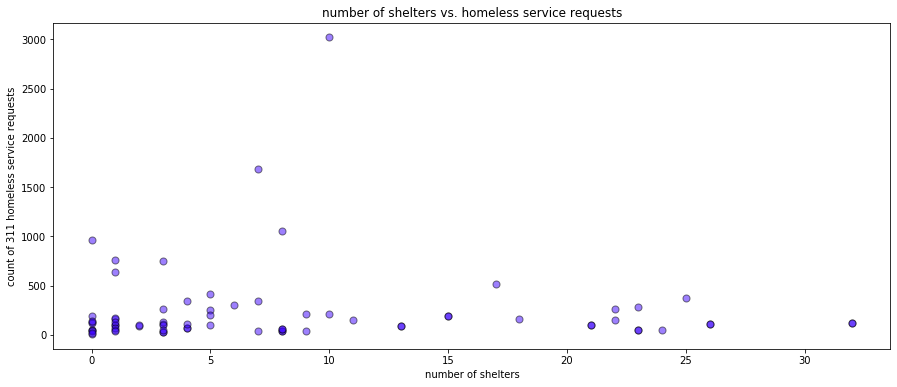

In [0]:
plt.figure(figsize=(15, 6))

plt.scatter(
    merged_data['sum'], # x
    merged_data['count_of_HPA_requests'], # y
    s=50, # size of marker
    c='#3d03fc', # color hex color picker: https://www.google.com/search?q=color+picker
    edgecolors='black', # outline color of the marker
    alpha=0.5) # transparency. 0 is 100% transparent. 1 is 100% opaque

plt.title('number of shelters vs. homeless service requests')
plt.xlabel('number of shelters')
plt.ylabel('count of 311 homeless service requests')

plt.show()

#Step 8
Use np.corrcoef(x, y) to identify the correlation coefficient between count of total shelter buildings and count of homeless requests per community district.

In [0]:
 np.corrcoef(merged_data['sum'], merged_data['count_of_HPA_requests'])

array([[ 1.        , -0.02042157],
       [-0.02042157,  1.        ]])

#Step 9
Perform a linear regression with count of total shelter buildings as the independent variable and count of homeless requests as the dependent variable

In [0]:
x = np.array(merged_data['sum'])
y = np.array(merged_data['count_of_HPA_requests'])

x = sm.add_constant(x)

print(x)

model = sm.OLS(y, x).fit()


print(model.summary())

[[ 1.  1.]
 [ 1.  0.]
 [ 1. 17.]
 [ 1.  8.]
 [ 1. 10.]
 [ 1.  3.]
 [ 1.  7.]
 [ 1.  1.]
 [ 1.  6.]
 [ 1. 23.]
 [ 1. 25.]
 [ 1.  3.]
 [ 1. 15.]
 [ 1. 15.]
 [ 1.  8.]
 [ 1.  8.]
 [ 1. 23.]
 [ 1. 23.]
 [ 1. 32.]
 [ 1. 32.]
 [ 1. 21.]
 [ 1. 21.]
 [ 1. 26.]
 [ 1. 26.]
 [ 1. 13.]
 [ 1. 13.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  8.]
 [ 1.  8.]
 [ 1.  3.]
 [ 1.  3.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  4.]
 [ 1.  4.]
 [ 1.  7.]
 [ 1.  5.]
 [ 1. 22.]
 [ 1. 10.]
 [ 1. 18.]
 [ 1.  4.]
 [ 1.  9.]
 [ 1. 11.]
 [ 1.  2.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  2.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1. 24.]
 [ 1.  4.]
 [ 1.  3.]
 [ 1.  5.]
 [ 1.  5.]
 [ 1.  5.]
 [ 1.  3.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  3.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  7.]
 [ 1.  0.]
 [ 1. 22.]
 [ 1.  9.]
 [ 1.  3.]
 [ 1.  1.]
 [ 1.  0.]
 [ 1.  0.]]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:     

#Step 10
Produce a scatter plot of the data with the line of best fit from your linear regression using the matplotlib package

parameters: [254.28120088  -0.98829495]
R2: 0.00041704046351909163
y = -0.99x + 254.28; R2 = 0.0


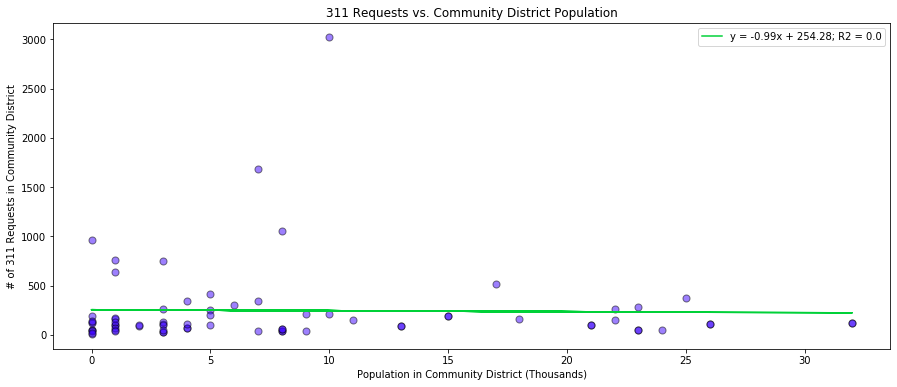

In [0]:

p = model.params # intercept and coefficient
print('parameters:', p)
r2 = model.rsquared
print('R2:', r2)
label = 'y = ' + str(round(p[1],2)) + 'x + ' + str(round(p[0],2)) + '; R2 = ' + str(round(r2,3))
print(label)

x_dummy =merged_data['sum']

plt.figure(figsize=(15, 6))

plt.scatter(
    merged_data['sum'], # x
    merged_data['count_of_HPA_requests'], # y
    s=50, # size of marker
    c='#3d03fc', # color hex color picker: https://www.google.com/search?q=color+picker
    edgecolors='black', # outline color of the marker
    alpha=0.5) # transparency. 0 is 100% transparent. 1 is 100% opaque

# line of best fit, with y intercept
plt.plot(
    x_dummy, 
    p[0] + p[1] * x_dummy,
    c='#00d138', # lighter green
    label=label)

plt.title('311 Requests vs. Community District Population')
plt.xlabel('Population in Community District (Thousands)')
plt.ylabel('# of 311 Requests in Community District')
plt.legend()

plt.show()

#Step 11
Write a sentence or two explaining the results of your analysis. What do the numbers and chart tell you about the relationship between concentration of homeless shelters vs. frequency of 311 requests related to homelessness?

In [0]:
#The concentration of homeless shelters and frequency of 311 requests related to homelessness is statistically insignificant. It's safe to say number of shelters and number of requests is uncorrelated.